<a href="https://colab.research.google.com/github/sleepsim/Week3-Machine_Learning/blob/main/Assignment3_pandres.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro

Assignment 3 - IAT481 SP 2024\
Pocholo Andres\
pandres@sfu.ca\
github.com/sleepsim

https://github.com/sleepsim/Week3-Machine_Learning
___



# Initialization

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

Importing Required libraries

In [1]:
#importing the required libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import librosa.display
import soundfile
import os
# matplotlib complains about the behaviour of librosa.display, so we'll ignore those warnings:
import warnings; warnings.filterwarnings('ignore')

#models used
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from joblib import parallel_backend
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Loading files

Loading Files from Drive

In [ ]:
features=pd.read_excel('/content/drive/MyDrive/IAT481/featuresCombined.xlsx',index_col=0)
emotions=pd.read_excel('/content/drive/MyDrive/IAT481/emotionsCombined.xlsx',index_col=0)

Loading Files Locally, (for local runtime since my computer is faster than free version of google collab)

In [2]:
# Loading locally for local runtime (faster processing than google CPU)
features=pd.read_excel(r"C:\Users\Pocholo\Desktop\481\featuresCombined.xlsx",index_col=0)
emotions=pd.read_excel(r"C:\Users\Pocholo\Desktop\481\emotionsCombined.xlsx",index_col=0)

Testing if files are loaded properly

In [3]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,0.617466,0.576461,0.569040,0.609814,0.654684,0.701384,0.735561,0.717063,0.728129,0.702318,...,-3.581316,-0.467617,-3.222230,0.313375,3.955157,-0.183977,1.367951,2.254531,-0.198084,4.343905
1,0.623919,0.574488,0.517403,0.513132,0.550291,0.568414,0.568268,0.579836,0.644346,0.689928,...,1.126486,3.953426,1.156003,6.056956,5.954752,3.322112,6.695466,4.928186,3.682733,4.037534
2,0.677821,0.616982,0.615782,0.621085,0.626168,0.646080,0.691546,0.685554,0.722938,0.696742,...,-1.149269,1.404988,-1.316433,3.550398,3.366586,0.352723,2.582228,2.148702,1.180273,4.521074
3,0.541733,0.565394,0.591974,0.606679,0.647344,0.677179,0.715182,0.705764,0.707652,0.667793,...,-2.528749,0.933915,-4.214124,1.486633,3.447144,0.343212,1.673163,1.149167,-1.704414,2.925104
4,0.473540,0.471911,0.494642,0.486543,0.527230,0.642038,0.701873,0.645157,0.621900,0.605100,...,1.344774,-0.028760,0.591915,0.167358,1.744662,-1.228223,-0.578519,0.850627,-1.625405,0.764073


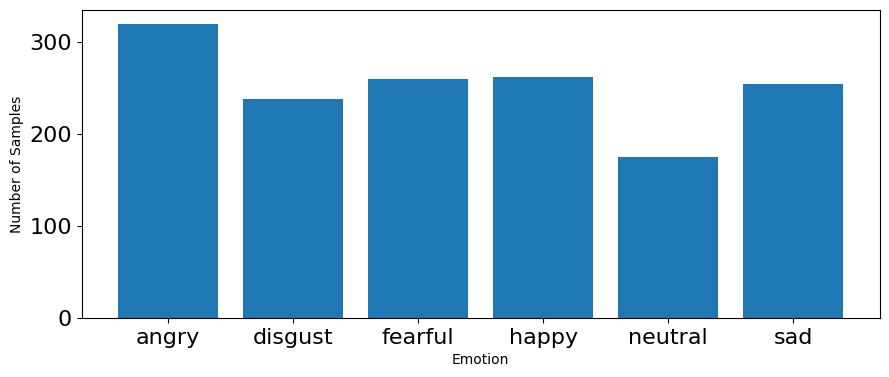

In [ ]:
# plot emotions
plt.figure(figsize=(35,4))
plt.subplot(1,3,1)
#np.unique returns ordered list of unique elements and count of each element
emotion_list, count = np.unique(emotions, return_counts=True)
plt.bar(x=range(6), height=count)
plt.xticks(ticks=range(6), labels = [emotion for emotion in emotion_list],fontsize=10)
plt.xlabel('Emotion')
plt.tick_params(labelsize=16)
plt.ylabel('Number of Samples')
plt.show()

In [5]:
print(f'\nAudio samples represented: {features.shape[0]}')
print(f'Numerical features extracted per sample: {features.shape[1]}')
features_df = pd.DataFrame(features) # make it pretty for display
labels_df=pd.DataFrame(emotions)


Audio samples represented: 1508
Numerical features extracted per sample: 180


# Feature Scaling

In [6]:
# We would usually use df.describe(), but it provides a bit of a mess of information we don't need at the moment.
def print_features(df):
    # Check chromagram feature values
    features_df_chromagram = df.loc[:,:11]
    chroma_min = features_df_chromagram.min().min()
    chroma_max = features_df_chromagram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    chroma_mean = features_df_chromagram.stack().mean()
    chroma_stdev = features_df_chromagram.stack().std()
    print(f'12 Chromagram features:       \
    min = {chroma_min:.3f}, \
    max = {chroma_max:.3f}, \
    mean = {chroma_mean:.3f}, \
    deviation = {chroma_stdev:.3f}')

    # Check mel spectrogram feature values
    features_df_melspectrogram = df.loc[:,12:139]
    mel_min = features_df_melspectrogram.min().min()
    mel_max = features_df_melspectrogram.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mel_mean = features_df_melspectrogram.stack().mean()
    mel_stdev = features_df_melspectrogram.stack().std()
    print(f'\n128 Mel Spectrogram features: \
    min = {mel_min:.3f}, \
    max = {mel_max:.3f}, \
    mean = {mel_mean:.3f}, \
    deviation = {mel_stdev:.3f}')

    # Check MFCC feature values
    features_df_mfcc = df.loc[:,140:179]
    mfcc_min = features_df_mfcc.min().min()
    mfcc_max = features_df_mfcc.max().max()
    # stack all features into a single series so we don't get a mean of means or stdev of stdevs
    mfcc_mean = features_df_mfcc.stack().mean()
    mfcc_stdev = features_df_mfcc.stack().std()
    print(f'\n40 MFCC features:             \
    min = {mfcc_min:.3f},\
    max = {mfcc_max:.3f},\
    mean = {mfcc_mean:.3f},\
    deviation = {mfcc_stdev:.3f}')

print("Before Scaling \n\n")
print_features(features_df)

Before Scaling 


12 Chromagram features:           min = 0.276,     max = 0.888,     mean = 0.640,     deviation = 0.093

128 Mel Spectrogram features:     min = 0.000,     max = 886.647,     mean = 1.328,     deviation = 9.748

40 MFCC features:                 min = -863.639,    max = 121.174,    mean = -11.163,    deviation = 82.575


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
# keep our unscaled features just in case we need to process them alternatively
features_scaled = features
features_scaled = scaler.fit_transform(features_scaled)

scaler = MinMaxScaler()
# keep our unscaled features just in case we need to process them alternatively
features_minmax = features
features_minmax = scaler.fit_transform(features_minmax)

In [8]:
print("After Scaling \n\n")
print('\033[1m'+'Standard Scaling:\n'+'\033[0m')
features_scaled_df = pd.DataFrame(features_scaled)
print_features(features_scaled_df)

print('\n\n\033[1m'+'MinMax Scaling:\n'+'\033[0m')
features_minmax_df = pd.DataFrame(features_minmax)
print_features(features_minmax_df)

After Scaling 


Standard Scaling:

12 Chromagram features:           min = -4.046,     max = 2.602,     mean = 0.000,     deviation = 1.000

128 Mel Spectrogram features:     min = -0.475,     max = 33.092,     mean = 0.000,     deviation = 1.000

40 MFCC features:                 min = -4.719,    max = 6.582,    mean = 0.000,    deviation = 1.000


MinMax Scaling:

12 Chromagram features:           min = 0.000,     max = 1.000,     mean = 0.599,     deviation = 0.179

128 Mel Spectrogram features:     min = 0.000,     max = 1.000,     mean = 0.024,     deviation = 0.068

40 MFCC features:                 min = 0.000,    max = 1.000,    mean = 0.393,    deviation = 0.177


# Machine Learning Setup

For this portion, I will test all the built in scikit learn methods for machine learning and find the best 3 methods with default parameters

But first, we must split the data 80/20 with 80% used for training and 20% used for testing

## Data Split 80/20

Split the dataset into 80/20 (Training/Testing)

The Random State I'll be using for splitting my set is  = 42

3 Different versions,
- Original unscaled
- Standard scaling
- MinMax scaling

The test set is initialized during original unscaled

In [9]:
from sklearn.model_selection import train_test_split

############# Unscaled test/train set #############
X_train, X_test, y_train, y_test =train_test_split(
    features,
    emotions,
    test_size=0.2,
    random_state=42
)

############ Standard Scaled test/train set ###########
# The labels/classes (y_train, y_test) never change, keep old values
X_train_scaled, X_test_scaled, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

############# MinMax Scaled test/train set ###############
# The labels/classes (y_train, y_test) never change, keep old values
X_train_minmax, X_test_minmax, _, _ = train_test_split(
    features_scaled,
    emotions,
    test_size=0.2,
    random_state=42
)

## Testing for the best 3 models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classification_models = [
    KNeighborsClassifier(),#(3),
    SVC(kernel='linear'),#, C=0.025),
    SVC(kernel='rbf'),
    DecisionTreeClassifier(),#max_depth=5),
    RandomForestClassifier(),#max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

scores = []
for model in classification_models:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    model_name = type(model).__name__
    if model_name=='SVC' and model.kernel=='rbf': model_name+=' RBF kernel'
    if model_name=='SVC' and model.kernel=='linear': model_name+=' linear'
    scores.append((model_name,(f'{100*score:.2f}%')))
# Make it pretty
scores_df = pd.DataFrame(scores,columns=['Classifier','Accuracy Score'])
scores_df.sort_values(by='Accuracy Score',axis=0,ascending=False)

,Classifier,Accuracy Score
4,RandomForestClassifier,66.56%
0,KNeighborsClassifier,59.60%
1,SVC linear,56.62%
3,DecisionTreeClassifier,45.03%
5,AdaBoostClassifier,39.07%
2,SVC RBF kernel,38.74%
6,GaussianNB,38.41%
7,QuadraticDiscriminantAnalysis,35.43%


The top 3 for my combined dataset (RAVDESS + EMODB) which contains 1508 samples is different from the lab example.

My Top 3:
- RandomForestClassifier - 66.56%
- KNeighbrsClassifier - 59.60%
- SVC Linear - 56.62%

Lab Example Top 3:
- RandomForestClassifier - 51.92%
- KNeighborsClassifier - 51.57%
- SVC (Linear) - 49.83%

For this notebook I will be testing RandomForest, KNeighborsClassifier, and SVC RBF (since this is the one used in the lab)

# Random Forest Classifier

The first model I'll be testing out is Random Forest as it scored the highest in the initial test.

First I'll test how the model performs with the default set, scaled, and minmax set.

After, I'll test it out using the optimizations done in lab and compare the results, then I plan to further optimize it and find the best possible combination using GridSearch from Week 4 lab

First I'm going to test out the default model using the 3 different

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#default model with seed = 10101
model = RandomForestClassifier(
    random_state=10101 #Keep it consistent
)

model.fit(X_train, y_train)
print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')
model.fit(X_train_scaled, y_train)
print(f'Default Random Forest Model\'s accuracy on scaled training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on scaled test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')
model.fit(X_train_minmax, y_train)
print(f'Default Random Forest Model\'s accuracy on minmax training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on minmaxtest set is {100*model.score(X_test_minmax, y_test):.2f}%\n')



Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 66.56%

Default Random Forest Model's accuracy on scaled training set is 100.00%
Default Random Forest Model's accuracy on scaled test set is 65.89%

Default Random Forest Model's accuracy on minmax training set is 100.00%
Default Random Forest Model's accuracy on minmaxtest set is 65.89%



There's not much difference between the sets but the default set seems to perform the best out of all 3

The training set has a 100% success rate which is a bit worrying since it might be overfitted.

## Comparison against RAVDESS Dataset

For my next test, I'll be using the optimizations used in the lab example, keeping my random state of = 10101

In [ ]:
#Modifications

model = RandomForestClassifier(
    n_estimators = 500,
    criterion ='entropy',
    warm_start = True,
    max_features = 'sqrt',
    oob_score = True, # more on this below
    random_state=10101 # Keep it consistent

)

model.fit(X_train, y_train)
print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')

Default Random Forest Model's accuracy on training set is 100.00%
Default Random Forest Model's accuracy on test set is 68.21%




The combined dataset scored around 16%~ better than the original RAVDESS set. For reference, the lab RAVDESS only set scored

Training set: 100%

Test set: 52.96%

Unsurprisingly, the combined set performed better than the RAVDESS only

## (EXTRA) Further Optimization

When compared in isolation

The score has improved 2%~,  from 66%->68%

To find the best version, I'll first examine the default values but list them out (except for random state which ill keep = 10101)

Also since I started doing the bulk of the work after Week 4, I'll try using grid search to find the best combo, I'll be testing the following attirbutes

- bootstrap: T/F
- criterion: gini/entropy/log_loss
- n_estimators: 10/100/300
- oob_score: T/F
- warm_start: T/F


In [ ]:
model = RandomForestClassifier(

)

default_params = {
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy','log_loss'],
    'max_depth': [None],
    'max_features': ['auto'],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'n_estimators': [10,100,300],
    'oob_score': [False, False],
    'random_state': [10101],
    'verbose': [0],
    'warm_start': [False, True]
}

grid = GridSearchCV(
     model,
     default_params,
     cv = 2,
     n_jobs = -1,
     verbose = 3
)

with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)

print("best combo: \n", grid.best_params_)
print("best estimator: \n", grid.best_estimator_)

Fitting 2 folds for each of 72 candidates, totalling 144 fits
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, oob_score=False, random_state=10101, verbose=0, warm_start=False;, score=0.491 total time=   0.2s
[CV 2/2] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, oob_score=False, random_state=10101, verbose=0, warm_start=False;, score=0.461 total time=   0.2s
[CV 1/2] END bootstrap=True, criterion=gini, max_depth=None, max_features=auto, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=10, oob_score=False, random_state=10101, verbose=0, warm_start=True;, score=0.491 total time=   0.

According to this, the best parameters are
```
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'oob_score': False, 'random_state': 10101, 'verbose': 0, 'warm_start': False}
```

I'm gonna go ahead and try what score I'll get with these


In [ ]:
model = RandomForestClassifier(
    bootstrap = False,
    criterion = 'entropy',
    max_depth = None,
    max_features = 'auto',
    max_leaf_nodes = None,
    min_impurity_decrease = 0.0,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_weight_fraction_leaf = 0.0,
    n_estimators = 100,
    oob_score = False,
    random_state = 10101,
    warm_start = False
)

model.fit(X_train, y_train)

print(f'Optimized Random Forest Train\'s score is {100*model.score(X_train, y_train):.2f}%')
print(f'Optimized Random Forest Train\'s score is {100*model.score(X_test, y_test):.2f}%')

Optimized Random Forest Train's score is 100.00%
Optimized Random Forest Train's score is 70.20%


Admittedly, I didn't go too much in depth and just tried changing easy to change values like TRUE/FALSE or n_estimators, but even with these small changes I was able to increase the score by another 2%.

I'm happy with the 100% Training and 70.20% Test scores, so I'll be moving on to testing other models.

# KNeighborsClassifier

The next best performing model is the KNeighborsClassifier and I'll be doing the same testing and using simple grid search to find the good params

First thing's first, try all three datasets

In [ ]:
#default model with seed = 10101
model = KNeighborsClassifier(
)

model.fit(X_train, y_train)
print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')
model.fit(X_train_scaled, y_train)
print(f'Default Random Forest Model\'s accuracy on scaled training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on scaled test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')
model.fit(X_train_minmax, y_train)
print(f'Default Random Forest Model\'s accuracy on minmax training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on minmaxtest set is {100*model.score(X_test_minmax, y_test):.2f}%\n')


Default Random Forest Model's accuracy on training set is 71.14%
Default Random Forest Model's accuracy on test set is 59.60%

Default Random Forest Model's accuracy on scaled training set is 76.87%
Default Random Forest Model's accuracy on scaled test set is 56.95%

Default Random Forest Model's accuracy on minmax training set is 76.87%
Default Random Forest Model's accuracy on minmaxtest set is 56.95%



Unlike the Random Forest Classifier, this model doesn't seem to be overfitted

Likewise, I'll be testing the tuning given in the lab example

Each set also had almost identical results

## Comparison against RAVDESS Dataset

Like earlier, I'll be using the optimizations used in the lab example

In [11]:
#WEEK 3 LAB EXAMPLE

##### (hastily) tuned kNN ######
model = KNeighborsClassifier(
    n_neighbors = 5,
    weights = 'distance',
    algorithm = 'brute',
    n_jobs=4
)

model.fit(X_train, y_train)

print(f'kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

kNN Model's accuracy on training set is 100.00%
kNN Model's accuracy on test set is 61.59%


The combined dataset scored about 11%~ higher than the RAVDESS dataset, a bit less than the random forest classifier. For reference, the original RAVDESS only scored the following

Training Set: 100%

Test Set: 49.48%

But like earlier, the combined set once agains scored better than the RAVDESS only set

## (EXTRA) Further Optimization

The accuracy jumped up for both training and test set, but I worry that the model is once again overfitted.

I'm going to try and optimize it even more using Grid Search again

In [ ]:
model = KNeighborsClassifier(
)

default_params = {
    'weights' : ['distance','uniform'],
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : [10, 30, 100, 200],
    'p' : [1,2],
    'metric' : ['minkowski']
}

grid = GridSearchCV(
     model,
     default_params,
     cv = 2,
     n_jobs = 1,
     verbose = 3
)

with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)

print("best combo: \n", grid.best_params_)

Fitting 2 folds for each of 64 candidates, totalling 128 fits
[CV 1/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=1, weights=distance;, score=0.537 total time=   0.2s
[CV 2/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=1, weights=distance;, score=0.542 total time=   0.2s
[CV 1/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=1, weights=uniform;, score=0.491 total time=   0.2s
[CV 2/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=1, weights=uniform;, score=0.507 total time=   0.4s
[CV 1/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=2, weights=distance;, score=0.504 total time=   0.1s
[CV 2/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=2, weights=distance;, score=0.473 total time=   0.1s
[CV 1/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=2, weights=uniform;, score=0.433 total time=   0.1s
[CV 2/2] END algorithm=auto, leaf_size=10, metric=minkowski, p=2, weights=uniform;, score=0.456 total time=   0.1s
[CV 1/2] END a

From the short grid search above, the best combination was found to be

In [ ]:
{'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'p': 1, 'weights': 'distance'}

I'm gonna go ahead and try these parameters


In [ ]:
model = KNeighborsClassifier(
    algorithm = 'auto',
    leaf_size = 10,
    metric = 'minkowski',
    p = 1,
    weights = 'distance'
)

model.fit(X_train, y_train)

print(f'Optimized kNN Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Optimized kNN Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Optimized kNN Model's accuracy on training set is 100.00%
Optimized kNN Model's accuracy on test set is 69.87%


Like the Random forest classifier, using the optimized parameters, the kNN model jumped up around 8%~ to 69.87% which is pretty close to the accuracy of the random forest classifier.

I also found that changing the leafsize does not change the accuracy of the model which is sort of confusing but I don't understand the other parametrs enough to know why

# SVC RBF

The last model I'll be testing and trying to optimize will be SVC RBF

Like the two previous models, I'll first test how the model performs with the default set, scaled, and minmax set.

In [16]:
#default model with seed = 10101
model = SVC(
    kernel = 'rbf',
    random_state = 10101
)

model.fit(X_train, y_train)
print(f'Default Random Forest Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%\n')
model.fit(X_train_scaled, y_train)
print(f'Default Random Forest Model\'s accuracy on scaled training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on scaled test set is {100*model.score(X_test_scaled, y_test):.2f}%\n')
model.fit(X_train_minmax, y_train)
print(f'Default Random Forest Model\'s accuracy on minmax training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'Default Random Forest Model\'s accuracy on minmaxtest set is {100*model.score(X_test_minmax, y_test):.2f}%\n')


Default Random Forest Model's accuracy on training set is 38.72%
Default Random Forest Model's accuracy on test set is 38.74%

Default Random Forest Model's accuracy on scaled training set is 65.84%
Default Random Forest Model's accuracy on scaled test set is 52.98%

Default Random Forest Model's accuracy on minmax training set is 65.84%
Default Random Forest Model's accuracy on minmaxtest set is 52.98%



The default result is very similar to the KNeighbors model where the scaled/min-max had identical scores with the original dataset doing poorly (probably because scaling the data should theoretically be better for SVC).

Next step is to optimize similar to the lab

## Comparison Against RAVDESS Dataset

Lab optimized parameters

In [17]:
model = SVC(
    C=10,  #higher the value tighter the margin
    gamma='auto',
    kernel='rbf',
    random_state=10101
)

model.fit(X_train, y_train)

print(f'SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

SVC Model's accuracy on training set is 100.00%
SVC Model's accuracy on test set is 49.01%


Very unusual results, unlike the two previous models, this model actually performed worse than the RAVDESS dataset, and the default also performed better

## (EXTRA) Further Optimization

Like the previous two models, I'm going to further optimize it using GridSearch

In [19]:
model = SVC(
)

default_params = {
    'kernel': ['rbf'], #These first two will never change
    'random_state': [10101],
    'C' : [1, 5, 10],
    'degree' : [2,3,4],
    'gamma' : ['scale', 'auto'],
    'shrinking': [True, False],
    'class_weight': [dict, 'balanced', None]
}

grid = GridSearchCV(
    model,
    default_params,
    cv = 2,
    n_jobs = 1,
    verbose = 3
)

with parallel_backend('multiprocessing'):
    grid.fit(X_train, y_train)

print("best combo: \n", grid.best_params_)

Fitting 2 folds for each of 108 candidates, totalling 216 fits
[CV 1/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=scale, kernel=rbf, random_state=10101, shrinking=True;, score=nan total time=   0.0s
[CV 2/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=scale, kernel=rbf, random_state=10101, shrinking=True;, score=nan total time=   0.0s
[CV 1/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=scale, kernel=rbf, random_state=10101, shrinking=False;, score=nan total time=   0.0s
[CV 2/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=scale, kernel=rbf, random_state=10101, shrinking=False;, score=nan total time=   0.0s
[CV 1/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=auto, kernel=rbf, random_state=10101, shrinking=True;, score=nan total time=   0.0s
[CV 2/2] END C=1, class_weight=<class 'dict'>, degree=2, gamma=auto, kernel=rbf, random_state=10101, shrinking=True;, score=nan total time=   0.0s
[CV 1/2] END C=1, class_weight=<class 'dict'>, de

Best params

In [ ]:
{'C': 10, 'class_weight': 'balanced', 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 10101, 'shrinking': True}

In [20]:
model = SVC(
    C = 10,
    class_weight = 'balanced',
    degree = 2,
    gamma = 'scale',
    kernel = 'rbf',
    random_state = 10101,
    shrinking = True
)


model.fit(X_train, y_train)

print(f'Optimized SVC Model\'s accuracy on training set is {100*model.score(X_train, y_train):.2f}%')
print(f'Optimized SVC Model\'s accuracy on test set is {100*model.score(X_test, y_test):.2f}%')

Optimized SVC Model's accuracy on training set is 52.24%
Optimized SVC Model's accuracy on test set is 48.34%


A 20% improvement over the original results of 38.72%/38.74%

But like earlier, I think this might be an inherent weakness of SVC, my theory is that since SVC plots the points, large differences in the value creates a larger area that the model needs to analyze and group.

By scaling the datapoints, the area that needs to be fitted is smaller which is why I think scaled datapoints perform better.

I'm unsatisfied with the current percentages so I'm going to try using the scaled datasets with the best params

In [30]:
model = SVC(
    C = 10,
    class_weight = 'balanced',
    degree = 2,
    gamma = 'scale',
    kernel = 'rbf',
    random_state = 10101,
    shrinking = True
)


model.fit(X_train_scaled, y_train)

print(f'[SCALED] Optimized SVC Model\'s accuracy on training set is {100*model.score(X_train_scaled, y_train):.2f}%')
print(f'[SCALED] Optimized SVC Model\'s accuracy on test set is {100*model.score(X_test_scaled, y_test):.2f}%')

print(f'[minmax] Optimized SVC Model\'s accuracy on training set is {100*model.score(X_train_minmax, y_train):.2f}%')
print(f'[minmax] Optimized SVC Model\'s accuracy on test set is {100*model.score(X_test_minmax, y_test):.2f}%')

[SCALED] Optimized SVC Model's accuracy on training set is 87.81%
[SCALED] Optimized SVC Model's accuracy on test set is 63.91%
[minmax] Optimized SVC Model's accuracy on training set is 87.81%
[minmax] Optimized SVC Model's accuracy on test set is 63.91%


As theorized, the model's accuracy increased a lot by using the scaled data,

87.81%/63.91% are percentages I'm satisfied with so that concludes this optimization and assignment

Thank you for reading through all of the text! :D

Repo link: https://github.com/sleepsim/Week3-Machine_Learning



# Credits/References

- Week 3 Lab
- https://www.sharpsightlabs.com/blog/scikit-train_test_split/
- https://www.sharpsightlabs.com/blog/sklearn-fit/
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
- https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html